## Clustering Mult. Poisson

In [34]:
import os.path
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import scipy.stats
import scipy
import math
import random
from scipy.stats import binom_test
from scipy.stats import kstest
from scipy.stats import norm
import sys 
from scipy.stats import binom
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.stats import poisson
import random
import numpy as np
from numpy.random import random
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import logging
import pickle
import matplotx

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
#Plot dendogram

with open(r'C:\Users\kianv\Documents\KariProject\multpois_states.pickle','rb') as handle:
    state_mean_dict = pickle.load(handle)
df = pd.read_csv(r'C:\Users\kianv\Documents\KariProject\dfmain.csv',header = 0,index_col='Date')
df.index = pd.to_datetime(df.index,format = '%Y-%m-%d')
del df['NumOfArticles']
#Loading data:
smoothed_data_all = np.zeros((len(list(df)),255))
for k in range(0,len(list(df))):
    ID = list(df)[k]
    arr = state_mean_dict[ID]
    smoothed_data = np.zeros(arr.shape[1])
    for i in range(arr.shape[1]):
        smoothed_data[i] = np.mean(arr[:,i])
    smoothed_data_all[k,:] = smoothed_data

Each Data Point is a row in the ```smooothed_data_all```

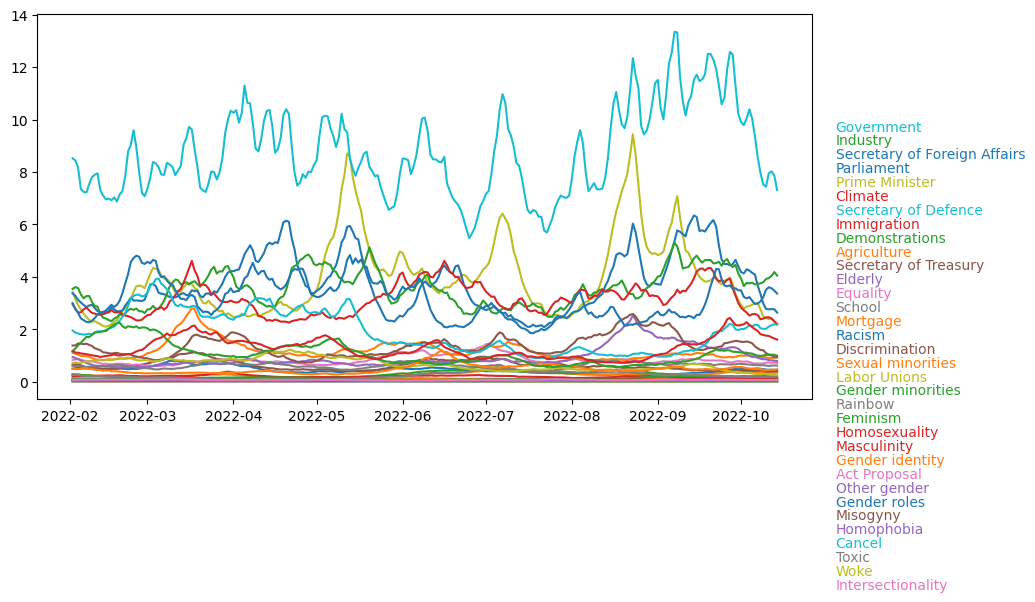

In [35]:
figure(figsize = (10,5))
for k in range(0,len(list(df))-1):
    plt.plot(df.index.values,smoothed_data_all[k,:], label = list(df)[k])
matplotx.line_labels()
plt.show()

Each curve clearly exhibits it's own unique behaviour. For example, government is consistently trending amongst the top key words whilst frequencies for gender minorities hardly occur. Since machine learning algorithms tend to have a bias towards variables that have greater magnitude and variance it is necessary for us to standardise our data. For the curves that are oscillating between 2 and 6 frequencies, there may be possible seasonality with respect to monthly or weekly data. However for curves between 0 and 2, is is difficult to understand how they correlate with curves oscillating between 2 and 6. There may be temporal correlations between these datapoints as a result of this seasonality. However is is important to transform our data since K-means deals in Euclidean Distance.

We can further investigate the relationship between our keywords by implementing K-means clustering.

Give definition of K-means clustering through MVA notes.

For data $\mathcal{X}=\left\{\mathbf{x}_1, \ldots, \mathbf{x}_n\right\} \subset \mathbb{R}^p$, a ( $k$ set) clustering consists of
1. a partition $C=\left\{C_1, \ldots, C_k\right\}$ of $\mathcal{X}$ such that $\mathcal{X}=\bigcup_{i=1}^k C_i$ and $C_i \cap C_j=\emptyset$ for all $i, j=1, \ldots, k$, such that $i \neq j$;
2. a set $Z=\left\{\mathbf{z}_1, \ldots, \mathbf{z}_k\right\} \subset \mathbb{R}^p$ of cluster centres.
The cost of a clustering is defined as
$$
\operatorname{cost}\left(C_1, \ldots, C_k, \mathbf{z}_1, \ldots, \mathbf{z}_k\right)=\sum_{i=1}^k \sum_{x \in C_i}\left\|\mathbf{x}-\mathbf{z}_i\right\|^2 .
$$

In order to increase the effectiveness of the K-means clustering algorithm, we can apply the Mahalanobis Transformation which centers, standardises and decorrelates our data. This can result in better clustering performance, as the clustering algorithm can focus on the most important dimensions of the data. Since we have applied this transformation we can compare the direction in which the data traverses through time.

Instead of directly applying K-means clustering which assigns a predetermined number of clusters, we can use hierarchical clustering.

Agglomerative clustering is a type of hierachical clustering that produces nested clusterings. The algorithm is initialsied with a n set clustering and merges clusters pairwsie until all datapoints belong to the same cluster.

The pre-determined nature of initialisation in the algorithm of agglomerative clustering is advantageous over k-means clustering where the randomness of choice of initialisation may change the clusterings.

One variable that we can control in Agglomerative clustering is the way in which we decide to merge clusters. Typically, there are common three ways inwhich we can choose to measure dissimilarities between sets of datapoints is to choose to merge datasets with the smallest linkages. In particular linkages pertaining to:

- Single Linkage
- Complete Linkage
- Average Linkage

Average Linkage may be sensitive to outliers whereas Single Linkage isn't.

Here we have our Mahalanobis Transformed Data.

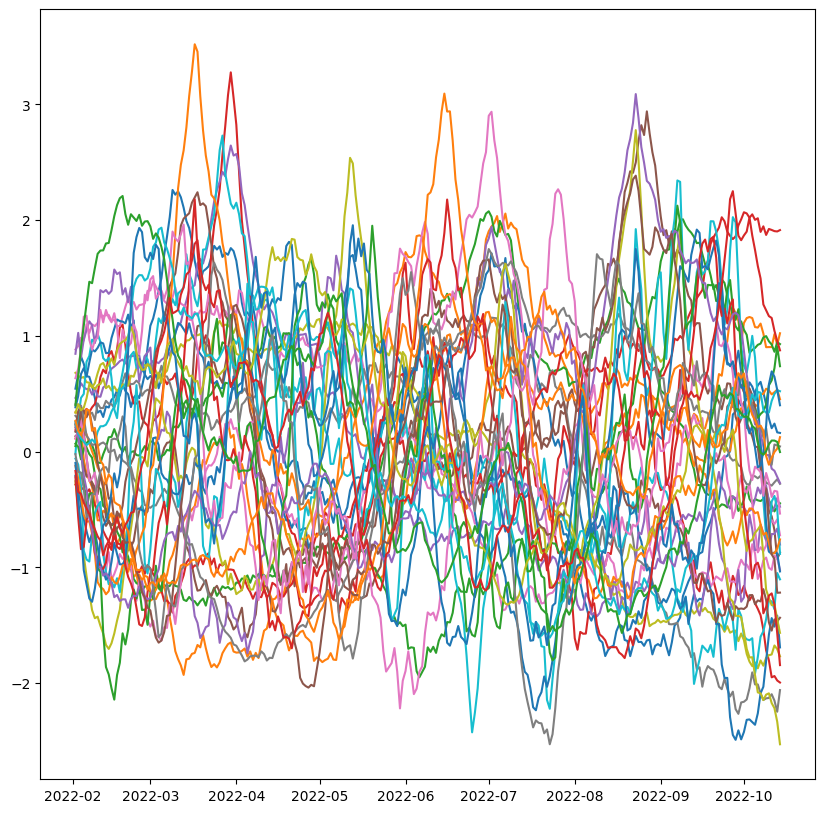

In [77]:
log_smoothed_data_all = np.copy(smoothed_data_all)
for i in range(0,smoothed_data_all.shape[0]):
    arr = smoothed_data_all[i,:]
    log_smoothed_data_all[i,:] = (np.log(arr)-np.mean(np.log(arr)))/np.std(np.log(arr))

figure(figsize = (10,10))
for k in range(0,len(list(df))-1):
    plt.plot(df.index.values,log_smoothed_data_all[k,:], label = list(df)[k])
#matplotx.line_labels()
plt.show()

We have our plots for the different types of clustering. These are obtained by cutting the dendogram at chosen thresholds specified below. Finding an interesting number of clusters in a dendrogram is the same as finding the largest horizontal space that has introspectively the longest vertical lines. This means that there's more separation between the clusters. We choose the thresholds as below:

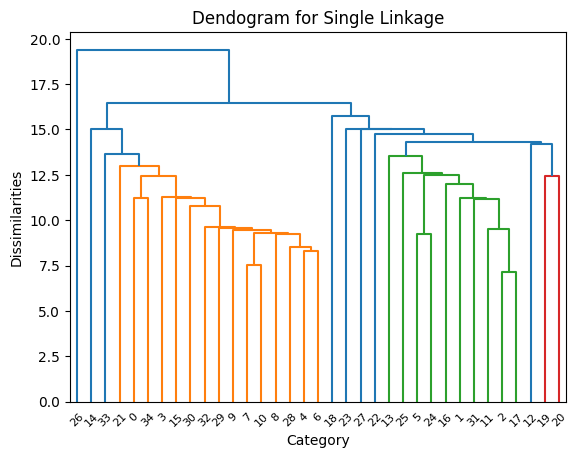

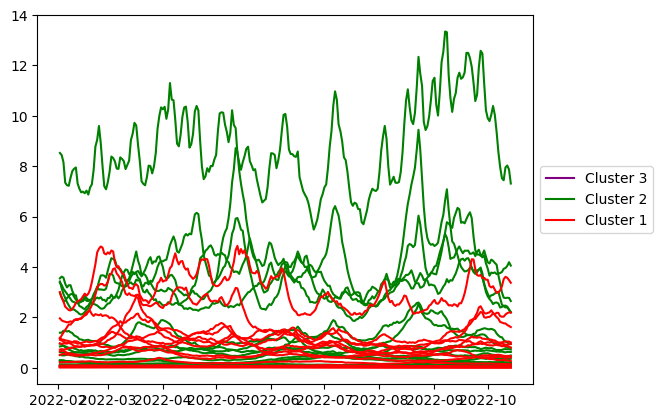

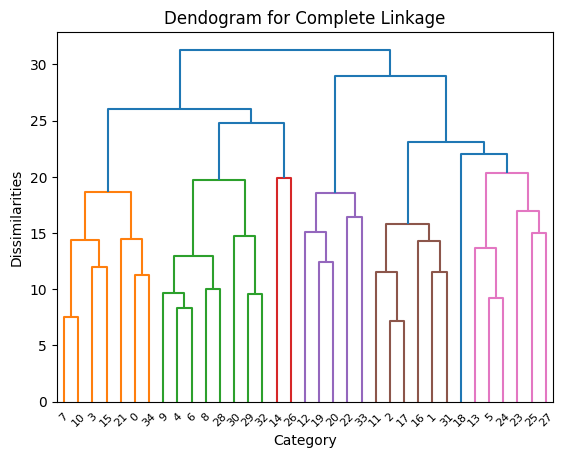

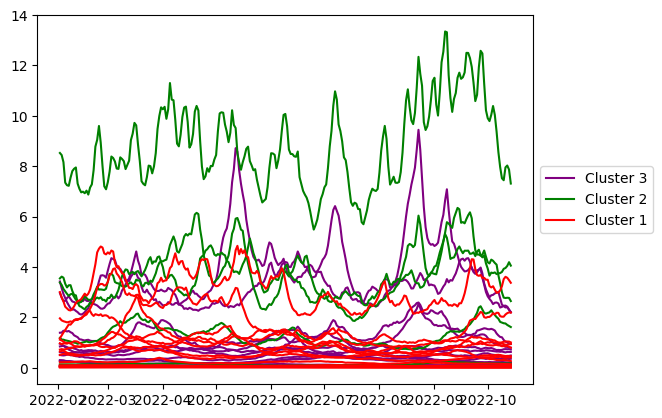

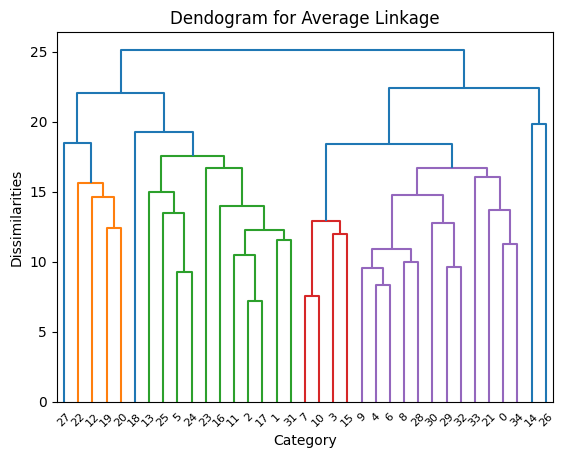

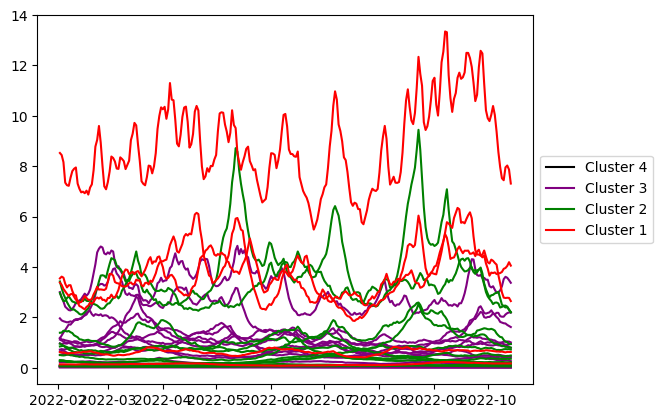

In [89]:
cdict = {0: 'blue', 1: 'red', 2: 'green',3: 'purple',4:'black',5:'cyan',6:'yellow',7:'magenta'}
with open("Clustering Linkages.txt", 'w') as file:
    linkage_data = linkage(log_smoothed_data_all, method='single', metric='euclidean')
    dendrogram(linkage_data)
    plt.ylabel("Dissimilarities")
    plt.xlabel("Category")
    plt.title("Dendogram for Single Linkage")
    plt.show()
    labels = scipy.cluster.hierarchy.fcluster(linkage_data, 16.0,criterion='distance')
    dfnplist = np.array(list(df))
    file.write("Single Linkage: \n \n")
    for k in range(0,max(labels)):
        I = np.argwhere(labels == k+1)
        file.write('Cluster ' + str(k+1))
        file.write("\n")
        for elem in dfnplist[I]:
            file.write(str(elem[0]))
            file.write('   ')
        file.write("\n")
        file.write("\n")

    inlegend = {}

    Z = [x for _,x in reversed(sorted(zip(labels,range(len(list(df))))))]
    for k in Z:
        if labels[k] in inlegend:
            thelabel = None
        else:
            thelabel = 'Cluster ' + str(labels[k])
            inlegend[labels[k]] = 1
        plt.plot(df.index.values,smoothed_data_all[k,:], label = thelabel, c = cdict[labels[k]])
    #matplotx.line_labels()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    

    linkage_data = linkage(log_smoothed_data_all, method='complete', metric='euclidean')
    dendrogram(linkage_data)
    plt.ylabel("Dissimilarities")
    plt.xlabel("Category")
    plt.title("Dendogram for Complete Linkage")
    plt.show()
    labels = scipy.cluster.hierarchy.fcluster(linkage_data, 27,criterion='distance')
    dfnplist = np.array(list(df))
    file.write("\n \nComplete Linkage: \n \n")
    for k in range(0,max(labels)):
        I = np.argwhere(labels == k+1)
        file.write('Cluster ' + str(k+1))
        file.write("\n")
        for elem in dfnplist[I]:
            file.write(str(elem[0]))
            file.write('   ')
        file.write("\n")
        file.write("\n")
    inlegend = {}
    Z = [x for _,x in reversed(sorted(zip(labels,range(len(list(df))))))]
    for k in Z:
        if labels[k] in inlegend:
            thelabel = None
        else:
            thelabel = 'Cluster ' + str(labels[k])
            inlegend[labels[k]] = 1
        plt.plot(df.index.values,smoothed_data_all[k,:], label = thelabel, c = cdict[labels[k]])
    #matplotx.line_labels()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    linkage_data = linkage(log_smoothed_data_all, method='average', metric='euclidean')
    dendrogram(linkage_data)
    plt.ylabel("Dissimilarities")
    plt.xlabel("Category")
    plt.title("Dendogram for Average Linkage")
    plt.show()
    labels = scipy.cluster.hierarchy.fcluster(linkage_data, 20.1,criterion='distance')
    dfnplist = np.array(list(df))
    file.write("\n \nAverage Linkage: \n \n")
    for k in range(0,max(labels)):
        I = np.argwhere(labels == k+1)
        file.write('Cluster ' + str(k+1))
        file.write("\n")
        for elem in dfnplist[I]:
            file.write(str(elem[0]))
            file.write('   ')
        file.write("\n")
        file.write("\n")

    inlegend = {}
    Z = [x for _,x in reversed(sorted(zip(labels,range(len(list(df))))))]
    for k in Z:
        if labels[k] in inlegend:
            thelabel = None
        else:
            thelabel = 'Cluster ' + str(labels[k])
            inlegend[labels[k]] = 1
        plt.plot(df.index.values,smoothed_data_all[k,:], label = thelabel, c = cdict[labels[k]])
    #matplotx.line_labels()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()



An alternative approach to determining the true number of clusters is to plot the
clustering cost against the number of clusters and try to find a kink or an elbow
in the curve after which the cost cannot be significantly reduced by increasing
the number of clusters (also known as a scree plot).

We run K-means++ (with better initialisation)

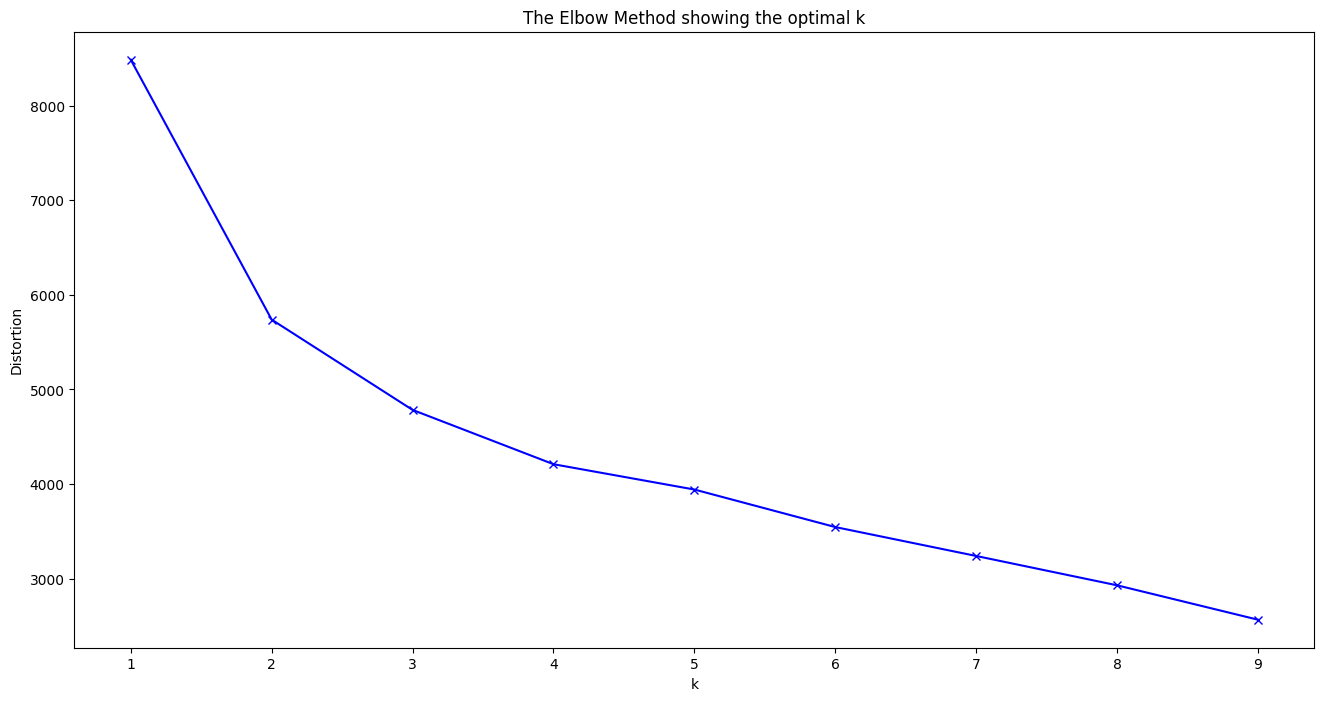

In [87]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k,n_init = 1,init='k-means++')
    kmeanModel.fit(log_smoothed_data_all)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

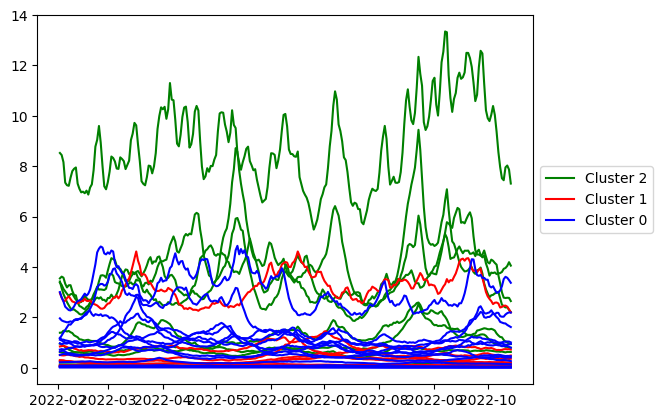

In [92]:
kmeanModel = KMeans(n_clusters=3,n_init = 1,init='k-means++')
modelled = kmeanModel.fit(log_smoothed_data_all)
labels = modelled.labels_
inlegend = {}
Z = [x for _,x in reversed(sorted(zip(labels,range(len(list(df))))))]
for k in Z:
    if labels[k] in inlegend:
        thelabel = None
    else:
        thelabel = 'Cluster ' + str(labels[k])
        inlegend[labels[k]] = 1
    plt.plot(df.index.values,smoothed_data_all[k,:], label = thelabel, c = cdict[labels[k]])
#matplotx.line_labels()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

We observe that the "elbow number" is 3 which is optimal for this case. Now we can rerun K-Means++ with the number of clusters as 3.

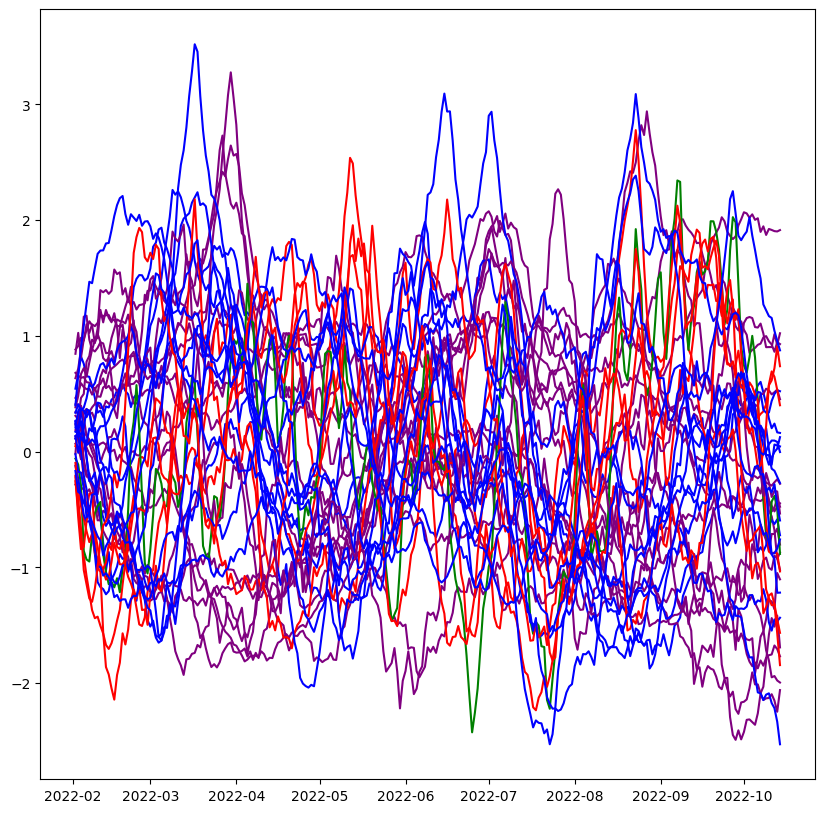

In [24]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(smoothed_data_all)

figure(figsize = (10,10))
cdict = {0: 'blue', 1: 'red', 2: 'green',3: 'purple',4:'black',5:'cyan',6:'yellow',7:'magenta'}
for k in range(0,len(list(df))):
    plt.plot(df.index.values,log_smoothed_data_all[k,:], label = list(df)[k], c = cdict[labels[k]])
#matplotx.line_labels()
plt.show()

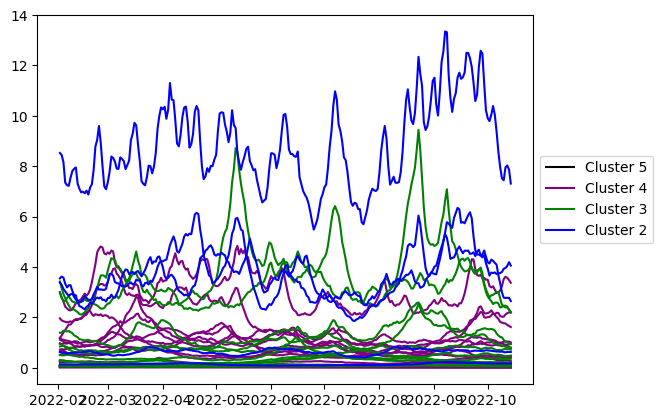

In [78]:
inlegend = {}

Z = [x for _,x in reversed(sorted(zip(labels,range(len(list(df))))))]
for k in Z:
    if labels[k] in inlegend:
        thelabel = None
    else:
        thelabel = 'Cluster ' + str(labels[k]+1)
        inlegend[labels[k]] = 1
    plt.plot(df.index.values,smoothed_data_all[k,:], label = thelabel, c = cdict[labels[k]])
#matplotx.line_labels()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [27]:
dfnplist = np.array(list(df))
with open("clustering output.txt", 'w') as file:
    for k in range(0,max(labels)+1):
        I = np.argwhere(labels == k)
        print(dfnplist[I])
        file.write('Cluster ' + str(k+1))
        file.write("\n")
        for elem in dfnplist[I]:
            file.write(str(elem[0]))
            file.write('   ')
        file.write("\n")
        file.write("\n")

[['Prime Minister']
 ['Parliament']
 ['Industry']
 ['Climate']
 ['Secretary of Foreign Affairs']]
[['Racism']
 ['Discrimination']
 ['Equality']
 ['Agriculture']
 ['Elderly']
 ['Secretary of Treasury']
 ['School']
 ['Labor Unions']
 ['Secretary of Defence']
 ['Mortgage']
 ['Demonstrations']
 ['Immigration']
 ['Secretary of State Home Office']]
[['Government']]
[['Sexual minorities']
 ['Gender minorities']
 ['Homosexuality']
 ['Homophobia']
 ['Misogyny']
 ['Intersectionality']
 ['Toxic']
 ['Woke']
 ['Cancel']
 ['Gender roles']
 ['Gender identity']
 ['Feminism']
 ['Masculinity']
 ['Other gender']
 ['Rainbow']
 ['Act Proposal']]


In [12]:
dfnplist

array(['Racism', 'Sexual minorities', 'Gender minorities',
       'Homosexuality', 'Homophobia', 'Misogyny', 'Intersectionality',
       'Toxic', 'Woke', 'Cancel', 'Gender roles', 'Gender identity',
       'Feminism', 'Masculinity', 'Other gender', 'Discrimination',
       'Equality', 'Rainbow', 'Prime Minister', 'Government',
       'Parliament', 'Agriculture', 'Industry', 'Climate', 'Elderly',
       'Secretary of Treasury', 'Act Proposal', 'School', 'Labor Unions',
       'Secretary of Defence', 'Secretary of Foreign Affairs', 'Mortgage',
       'Demonstrations', 'Immigration', 'Secretary of State Home Office'],
      dtype='<U30')

In [191]:
hashmap = {}
k = 0
for k in range(len(labels)):
    label = str(labels[k])
    print("label is: ", label)

    if label in hashmap.keys():
        print('l')
        hashmap[label].append(list(df)[k]) 
        print(type(hashmap))
        print('h')
        print(label)
    elif label not in hashmap.keys():
        dummy = list(df)[k]
        print(label)
        print("dict is: ",type(hashmap))
        print('here is hashmap: ',hashmap)
        hashmap[label] = 0 #[str(dummy)]
        print('here is hashmap: ',hashmap)
    else:
        print("errro")    

    k+=1
    hashmap = list(df)[k]

label is:  7
7
dict is:  <class 'dict'>
here is hashmap:  {}
here is hashmap:  {'7': 0}
label is:  3


AttributeError: 'str' object has no attribute 'keys'

In [188]:
labels

array([7, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 1, 3, 4, 5, 6, 1,
       0, 0, 1, 1, 3, 7, 7, 2, 0, 7, 1, 1, 1], dtype=int64)

In [155]:
hashmap['3'] = [list(df)[1]]

TypeError: 'str' object does not support item assignment

In [132]:
smoothed_data_all_df = df

In [136]:
for k in range(len(list(df))):
    smoothed_data_all_df[list(df)[k]] = list(log_smoothed_data_all[k,:])

In [137]:
smoothed_data_all_df.to_csv('dfsmoothedstatesmultpois.csv')

In [138]:
df_toR = df.copy

<Figure size 3200x6400 with 0 Axes>

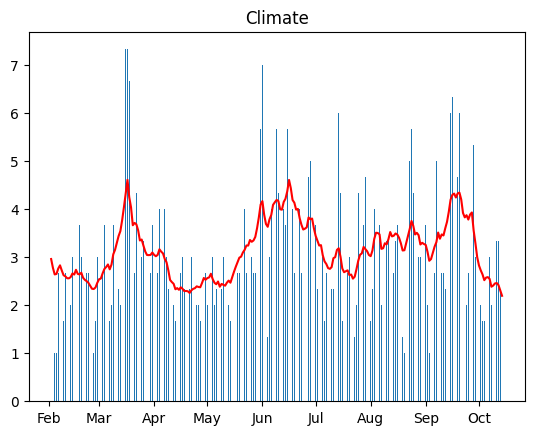

In [34]:
ID = 'Climate'
arr = state_mean_dict[ID]
smoothed_data = np.zeros(arr.shape[1])
for i in range(arr.shape[1]):
    smoothed_data[i] = np.mean(arr[:,i])
smoothed_data_all[ID] = smoothed_data
#storeageofstates[ID] = list(smoothed_data)
#storeageofstates.to_csv('storesmoothedstates.csv')
vals = df[ID]
df_dummy = df.copy()
# [rate,ParticleStates,Indicies] = self.general_filter(self.df[ID],N)
# self.SMCstates[ID] = Indicies
#np.savetxt("States.txt",Indicies , delimiter=",")

#dfp.rolling(7, center=True).mean()
hi = pd.DataFrame(vals)
dude = pd.DataFrame(hi).rolling(3, center=True).mean()        

df_dummy['Plottingrate'] = smoothed_data
figure(figsize=(10, 20), dpi=320)
fig, ax = plt.subplots()
plt.plot(df.index.values,df_dummy['Plottingrate'], color = 'red')
ax.bar(df.index.values, dude[ID] ,width = 0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Only plot the month
plt.title(ID)
plt.show()

In [32]:
smoothed_data

array([2.96357761, 2.7801251 , 2.64298384, 2.65256735, 2.76426631,
       2.8323235 , 2.72414965, 2.62622684, 2.60368394, 2.56357578,
       2.56170505, 2.58753814, 2.66338184, 2.63969042, 2.73896777,
       2.65258278, 2.64382072, 2.67762297, 2.57286178, 2.52914276,
       2.50298785, 2.46782555, 2.40732486, 2.34461829, 2.33868565,
       2.37106335, 2.46818745, 2.5426774 , 2.5565096 , 2.66492814,
       2.75625513, 2.79726072, 2.85046597, 2.74921494, 2.84814106,
       3.06209489, 3.15612217, 3.30357298, 3.44312282, 3.54558873,
       3.77391591, 4.04305559, 4.33203472, 4.61319147, 4.25046268,
       4.04030057, 3.66712689, 3.71531092, 3.68760754, 3.56222936,
       3.35045015, 3.37012752, 3.24128065, 3.12095251, 3.04757723,
       3.04492512, 3.04908125, 3.09941098, 3.05007965, 3.02200922,
       3.04940264, 3.16575451, 3.11699903, 3.08116131, 2.96464214,
       2.89630737, 2.729469  , 2.52776518, 2.48311442, 2.44699393,
       2.33347989, 2.35759341, 2.32256432, 2.37456796, 2.34425